<h1>Rocket Simulation</h1>
<p>Since the numbers are all so large here, it doesn't seem like a vpython application is the right move here. Instead, I'll use Matplotlib for visualization. The goal is to build up a successively complex rocket simulation that incorporates drag and other forces that I've learned about thus far in intro mechanics.</p>
<p>The performance of this rocket will be based loosley on the Delta II. For specs, I used the following source: https://www.spacelaunchreport.com/delta2.html.</p>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from rocket import Rocket, Stage, Payload
from vector import Vector
from math import exp, isclose
import json

Rocket Stats: 

Drag Coefficient: 0.82
Cross Sectional Area: 7.07
Stage dry mass is 5680.00kg, fuel mass is 96120.00kg, max thrust is 1100000.00N, and max fuel comsumption rate is 368.98kg/s.

Stage dry mass is 950.00kg, fuel mass is 6000.00kg, max thrust is 43640.00N, and max fuel comsumption rate is 13.90kg/s.

Payload mass is 2800.00kg.

Total mass: 111550.00 kg
7000
{'cmds': [{'throttle': 100.0, 'summary': 'Ignition of main stage.'}]}
{'throttle': 100.0, 'summary': 'Ignition of main stage.'}
Summary: Ignition of main stage.
{'cmds': [{'throttle': 0.0, 'separate': True, 'summary': 'MECO!'}]}
{'throttle': 0.0, 'separate': True, 'summary': 'MECO!'}
Summary: MECO!
{'cmds': [{'throttle': 100.0, 'summary': 'Ignition of second stage.'}]}
{'throttle': 100.0, 'summary': 'Ignition of second stage.'}
Summary: Ignition of second stage.
{'cmds': [{'throttle': 0.0, 'separate': True, 'summary': 'Second stage cut-off.'}]}
{'throttle': 0.0, 'separate': True, 'summary': 'Second stage cut-off.'}
Summ

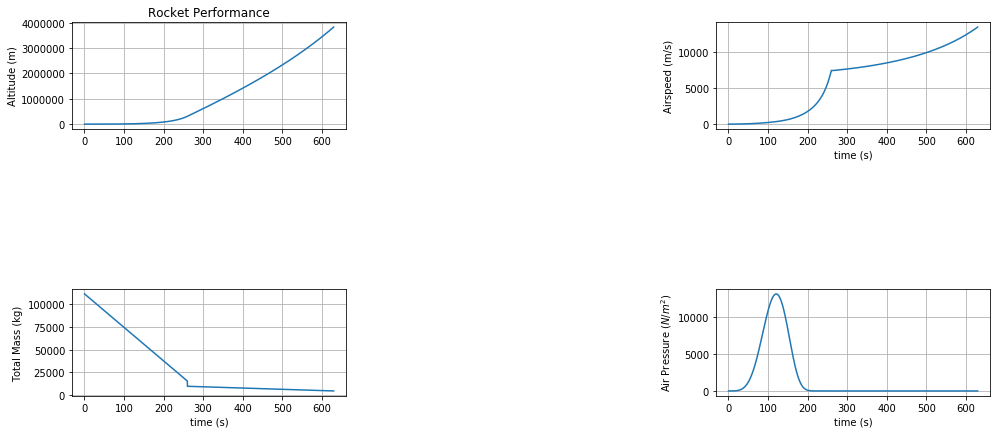

Max Q is 13188.14N/m^2.


In [24]:
# world constants and variables
g = 9.8 # acceleration due to gravity near the Earth's surface
dt = 0.01 # simulation time step
t = 0 # simulation time

# atmosphere
rho_air = lambda altitude: 1.225*exp(-altitude/8500) # atmospheric density as a function of altitude

def atmo_pressure(altitude):
    if altitude >= 2.5E4:
        T = -131.21 + 0.00299*altitude
        P = 2.488*((T+273.1)/216.6)**-11.388
    elif altitude >= 1.1E4 and altitude < 2.5E4:
        T = -56.46
        P = 22.65*np.exp(1.73 - 0.000157*altitude)
    else:
        T = 15.04 - 0.00649*altitude
        P = 101.29*((T+273.1)/288.08)**5.256
        
    #convert from kPa to Pa and return
    return P*1000

# Create a rocket
deltaII = Rocket(pos=Vector(0,0,0), coeff_drag=0.82, cross_sec_area=np.pi*1.5**2)
main_stage = Stage({"dry_mass": 5.680E3, "fuel_mass": 9.6120E4, "max_thrust_mag": 1.10E6, "max_dmdt": 368.98}) #8.89659E5
second_stage = Stage({"dry_mass": 950.0, "fuel_mass": 6000.0, "max_thrust_mag": 4.3640E4, "max_dmdt": 13.9})
deltaII.add_stage(main_stage)
deltaII.add_stage(second_stage)
payload = Payload(mass=2800.0)
deltaII.add_payload(payload)

print(deltaII)

# load flight plan from file
with open('flt-plan.json') as f:
  flt_plan = json.load(f)

total_data_points = 0

if len(flt_plan) > 0:
    cmd = flt_plan[-1]
    try:
        total_data_points = int(float(next(iter(cmd)))) * 10
        print(total_data_points)
    except:
        raise ValueError   
    
# data collection variables
idx = 0
data_point_counter = 0
data_time = np.zeros(total_data_points)
data_altitude = np.zeros(total_data_points)
data_velocity = np.zeros(total_data_points)
data_mass = np.zeros(total_data_points)
data_pressure = np.zeros(total_data_points)

def check_flt_plan(time):
    global flt_plan, EOM
    tm = "{:0.2f}".format(time)
    menu = next((d for i,d in enumerate(flt_plan) if tm in d), None)
    if menu is not None:
        # loop through instruction set
        menu = menu.get(tm)
        print(menu)
        cmds = menu.get("cmds", [])
        # loop through the commands in this menu and execute them in turn
        for cmd in cmds:
            print(cmd) # TODO: remove this statement once all flt plan commands are debugged.
            if cmd.get("throttle", None) is not None:
                deltaII.adjust_throttle(cmd["throttle"])
            if cmd.get("separate", None) is not None:
                deltaII.separate_active_stage()
            if cmd.get("EOM", None) is not None:
                EOM = True
            # print command summary
            print("Summary: {:}".format(cmd.get("summary", "None")))

EOM = False
while not EOM:
    
    # check flight plan for updates
    check_flt_plan(t)
    
    # calculate net force on rocket
    Fgrav = Vector(0,-deltaII.get_total_mass()*g,0)
    velocity = deltaII.momentum/deltaII.get_total_mass()
    
    if velocity.mag() > 0:
        Fdrag = -1/2*deltaII.coeff_drag*deltaII.cross_sec_area*rho_air(deltaII.pos.y)*velocity.mag()**2*velocity.hat()
    else:
        Fdrag = Vector(0,0,0)
        
    Fnet = deltaII.get_active_stage_thrust() + Fgrav + Fdrag
    
    # update the rocket's momentum
    deltaII.momentum = deltaII.momentum + Fnet*dt
    
    # update the rockets position
    deltaII.pos = deltaII.pos + deltaII.momentum/deltaII.get_total_mass()*dt
    
    deltaII.update_total_mass(dt)
    
    if data_point_counter == 9 and idx < total_data_points:
        data_point_counter = 0
        data_time[idx] = t
        data_altitude[idx] = deltaII.pos.y
        data_velocity[idx] = (deltaII.momentum/deltaII.get_total_mass()).mag()
        data_mass[idx] = deltaII.get_total_mass()
        data_pressure[idx] = Fdrag.mag()/deltaII.cross_sec_area
        idx += 1
    
    data_point_counter += 1
    t += dt
    
    if t > 800.0:
        EOM = True

plt.figure(figsize=(15, 15))
    
plt.subplot(4, 2, 1)
plt.plot(data_time, data_altitude)
plt.title('Rocket Performance')
plt.ylabel('Altitude (m)')
plt.grid(True)

plt.subplot(4, 2, 2)
plt.plot(data_time, data_velocity)
plt.xlabel('time (s)')
plt.ylabel('Airspeed (m/s)')
plt.grid(True)

plt.subplot(4, 2, 3)
plt.plot(data_time, data_mass)
plt.xlabel('time (s)')
plt.ylabel('Total Mass (kg)')
plt.grid(True)

plt.subplot(4, 2, 4)
plt.plot(data_time, data_pressure)
plt.xlabel('time (s)')
plt.ylabel('Air Pressure ($N/m^2$)')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1.5, wspace=1.35)
plt.show()

max_Q = np.amax(data_pressure)
print("Max Q is {:0.2f}N/m^2.".format(max_Q))